In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import mlgrad.model as model

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
_noise = 0.3
X, Y = datasets.make_moons(n_samples=200, noise=_noise, random_state=0)
N = len(X)
Y = 2.0*Y-1.0
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

# I1 = np.array([i for i in range(N) if Y[i] == 1])
# I2 = np.array([i for i in range(N) if Y[i] == -1])
# print(I1)
# print(I2)
# X1 = np.array([X[i,1] for i in I1])
# X2 = np.array([X[i,1] for i in I2])
# J1 = np.argsort(X1)
# J2 = np.argsort(X2)

# print(J1)
# print(J2)

(200, 2) (200,)
float64 float64


In [4]:
Y_o = np.array([y for y in Y])

In [5]:
# M=10
# for k in range(M//2):
#     j1 = J1[k]
#     i1 = I1[j1]
#     Y_o[i1] = -Y[i1]
# for k in range(M//2):
#     j2 = J2[-k-1]
#     i2 = I2[j2]
#     Y_o[i2] = -Y[i2]
# noise = M / 200
noise = _noise

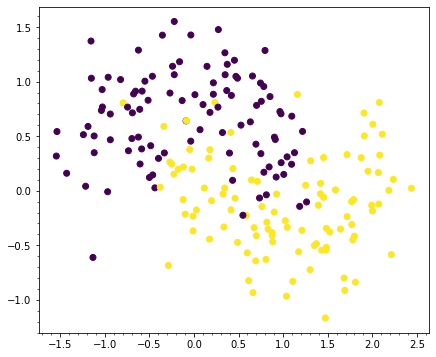

In [6]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y_o)
plt.minorticks_on()
plt.show()

In [7]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

def new_model(n):
    mod = model.SigmaNeuronModel(Sigmoidal(), n)
    mod.init_param()
    return mod

m = 30

In [8]:
gb = gb_fit(X, Y_o, new_model, n_iter=m, n_iter2=22)
lfm, lvals = gb.complex_model, gb.lvals
print(np.asarray(lfm.weights))

[ 1.26113842  0.24547572 -0.02752262 -0.00909658 -0.01069418 -0.00607116
 -0.00359421  0.0115311   0.02032027  0.0152825   0.02322864  0.02752662
  0.02812905  0.02756181  0.0268961   0.02643513  0.02621688  0.02600496
  0.02593946  0.02594451  0.02588089  0.02589519  0.02592093  0.02598146
  0.02595447  0.02599063  0.02597874  0.02597992  0.02596201  0.02597797]


In [9]:
alpha=0.98
gb_agg = gb_fit_agg(X, Y_o, new_model, aggname='WM', alpha=alpha, n_iter=m, n_iter2=22)
lfm_agg, lvals_agg = gb_agg.complex_model, gb_agg.lvals
print(np.asarray(lfm_agg.weights))

[ 0.22156218  0.10549833  0.15424313  0.74599527 -0.07597083 -0.03506079
 -0.04665333 -0.02791087 -0.0095372  -0.01377175 -0.01241395 -0.01230437
 -0.07990335 -0.04014498 -0.02215633 -0.03979597 -0.02746635 -0.01605753
 -0.01187478 -0.01427148 -0.00939769 -0.01234358 -0.01140014  0.00158954
  0.0021498   0.00160873  0.0010462   0.00297655  0.00392876  0.00134019]


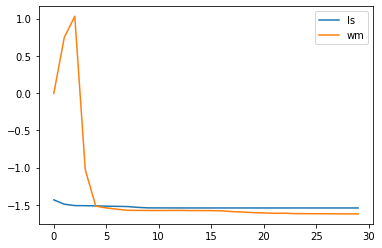

In [10]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.show()

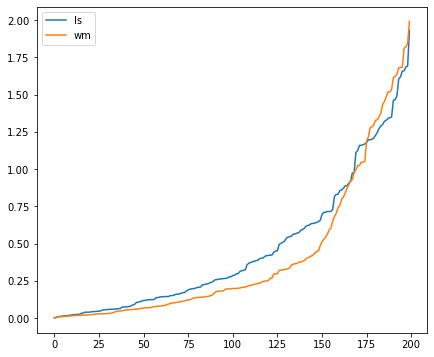

In [11]:
plt.figure(figsize=(7,6))
plt.plot(sorted([abs(lfm(X[k])-Y[k]) for k in range(len(X))]), label='ls')
plt.plot(sorted([abs(lfm_agg(X[k])-Y[k]) for k in range(len(X))]), label='wm')
plt.legend()
plt.show()

In [12]:
Y_ls = np.sign(lfm.evaluate_all(X))
Y_agg = np.sign(lfm_agg.evaluate_all(X))
acc_ls = 100*round(metrics.accuracy_score(Y_o, Y_ls), 3)
acc_wm = 100*round(metrics.accuracy_score(Y_o, Y_agg), 3)

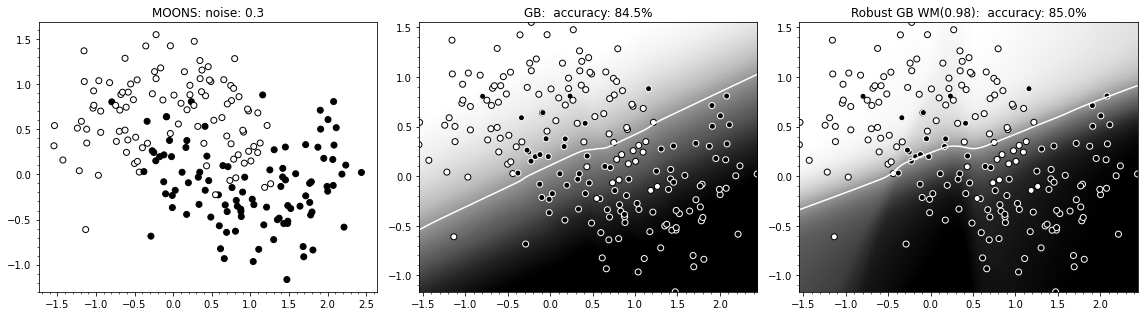

In [13]:
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xrange = np.linspace(x_min, x_max, 100)
yrange = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(xrange, yrange)
X2 = np.c_[XX.ravel(), YY.ravel()]
Z2_ls = np.array([lfm(Xk) for Xk in X2])
Z2_agg = np.array([lfm_agg(Xk) for Xk in X2])
np.putmask(Z2_ls, Z2_ls > 1, 1) 
np.putmask(Z2_ls, Z2_ls < -1, -1) 
np.putmask(Z2_agg, Z2_agg > 1, 1) 
np.putmask(Z2_agg, Z2_agg < -1, -1) 
ZZ_ls = Z2_ls.reshape(XX.shape)
ZZ_agg = Z2_agg.reshape(XX.shape)

edgecolors = [('w' if y == 1.0 else 'k') for y in Y_o]

levels = [ 0.,]
plt.figure(figsize=(16,4.5))
plt.subplot(1,3,1)
plt.title("MOONS: noise: %.1f" % noise)
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors='k', cmap=plt.cm.Greys)
plt.minorticks_on()
plt.subplot(1,3,2)
plt.title("GB:  accuracy: %.1f%%" % (acc_ls))
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors=edgecolors, cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_ls, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_ls, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.subplot(1,3,3)
plt.title("Robust GB WM(%.2f):  accuracy: %.1f%%" % (alpha, acc_wm))
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors=edgecolors, cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_agg, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_agg, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('rob_gb_%.0f.eps' % round(noise*100))
plt.show()

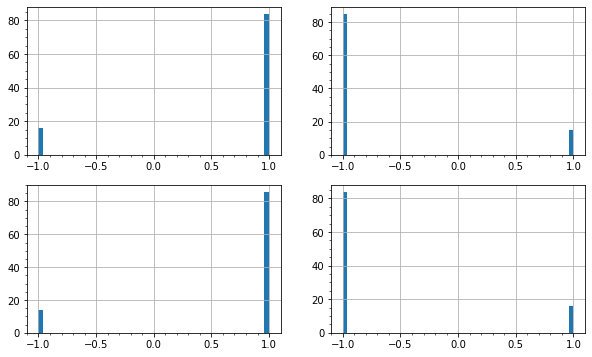

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.hist(Y_ls[Y_o == 1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,2)
plt.hist(Y_ls[Y_o == -1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,3)
plt.hist(Y_agg[Y_o == 1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,4)
plt.hist(Y_agg[Y_o == -1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.show()